# Football Player Value
- Data From : https://www.transfermarkt.com/
    * 트랜스퍼마켓 : 공신력 있는 축구선수 이적 관련 사이트
- Subject : 축구선수 몸값은 어떻게 결정될까?
    * 1. 축구가 산업화된 잉글랜드 프리미어리그에선 영국 국적이 몸값에 영향을 준다고 한다. 정말?
    * 2. 골, 어시스트, 키, 몸무게, 국적, 소속팀, 소속팀 성적, 소속팀 소속 리그 등 다양한 변수 활용
- Project Process
    * 1. 웹크롤링으로 데이터 확보
    * 2. 확보한 데이터 병합
    * 3. EDA 및 데이터전처리
    * 4. 서브주제에 맞춰 다양한 ML모델 사용
- Stack : Beautiful Soup 4, Pandas, Seaborn, Scikit-Learning

In [27]:
from bs4 import BeautifulSoup
from selenium import webdriver
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
# 정규표현식

from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV # 데이터 나누기, 점검 및 훈련
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, precision_score, recall_score # 평가지표
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR, LinearSVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from sklearn.pipeline import make_pipeline
import multiprocessing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import time

In [ ]:
data = pd.read_csv("data/data.csv", index_col=0)

## 1. 축구선수 몸값 데이터 확보
- webcrawling
- transfer markt

In [17]:
# 페이지 넘어가는 url 찾는 법
# 페이지 넘기는 링크(버튼) 우클릭 -> 링크 복사 -> 붙여넣기 -> url에 page= 있음. -> 여기에 page값 입력해 확인해보기
url = "https://www.transfermarkt.com/spieler-statistik/wertvollstespieler/marktwertetop?land_id=0&ausrichtung=alle&spielerposition_id=alle&altersklasse=alle&jahrgang=0&kontinent_id=0&plus=1&page={}".format(1)
headers = {'User-Agent' : "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/92.0.4515.159 Safari/537.36"}
r = requests.get(url, headers=headers)
r.status_code

200

In [18]:
soup = BeautifulSoup(r.text, "html.parser")

In [19]:
player = soup.find_all('tr', class_=['odd', 'even'])
player

[<tr class="odd">
 <td class="zentriert">1</td><td class=""><table class="inline-table"><tr><td rowspan="2"><a href="#"><img alt="Kylian Mbappé" class="bilderrahmen-fixed" src="https://img.a.transfermarkt.technology/portrait/small/342229-1632686046.jpg?lm=1" title="Kylian Mbappé"/></a></td><td class="hauptlink"><a href="/kylian-mbappe/profil/spieler/342229" title="Kylian Mbappé">Kylian Mbappé</a></td></tr><tr><td>Centre-Forward</td></tr></table></td><td class="zentriert">23</td><td class="zentriert"><img alt="France" class="flaggenrahmen" src="https://tmssl.akamaized.net/images/flagge/verysmall/50.png?lm=1520611569" title="France"/></td><td class="zentriert"><a href="/fc-paris-saint-germain/startseite/verein/583" title="Paris Saint-Germain"><img alt="Paris Saint-Germain" class="" src="https://tmssl.akamaized.net/images/wappen/verysmall/583.png?lm=1522312728" title=" "/></a></td><td class="rechts hauptlink"><a href="/kylian-mbappe/marktwertverlauf/spieler/342229">€160.00m</a> </td><td c

In [24]:
data = player[0].find_all('td')
data

[<td class="zentriert">1</td>,
 <td class=""><table class="inline-table"><tr><td rowspan="2"><a href="#"><img alt="Kylian Mbappé" class="bilderrahmen-fixed" src="https://img.a.transfermarkt.technology/portrait/small/342229-1632686046.jpg?lm=1" title="Kylian Mbappé"/></a></td><td class="hauptlink"><a href="/kylian-mbappe/profil/spieler/342229" title="Kylian Mbappé">Kylian Mbappé</a></td></tr><tr><td>Centre-Forward</td></tr></table></td>,
 <td rowspan="2"><a href="#"><img alt="Kylian Mbappé" class="bilderrahmen-fixed" src="https://img.a.transfermarkt.technology/portrait/small/342229-1632686046.jpg?lm=1" title="Kylian Mbappé"/></a></td>,
 <td class="hauptlink"><a href="/kylian-mbappe/profil/spieler/342229" title="Kylian Mbappé">Kylian Mbappé</a></td>,
 <td>Centre-Forward</td>,
 <td class="zentriert">23</td>,
 <td class="zentriert"><img alt="France" class="flaggenrahmen" src="https://tmssl.akamaized.net/images/flagge/verysmall/50.png?lm=1520611569" title="France"/></td>,
 <td class="zentri

In [32]:
ranking = data[0].text
print(ranking)
name = data[3].text
print(name)
position = data[4].text
print(position)
nation = data[6].img['alt'] #data[6].title로 입력해도 된다.
print(nation)
club = data[7].img['alt']
print(club)
value = data[8].text.strip()
print(value)
matches = data[9].text
print(matches)
goal = data[10].text
print(goal)
assist = data[12].text
print(assist)
yellow = data[13].text
print(yellow)
red = data[15].text
print(red)
subsin = data[16].text
print(subsin)
subsout = data[17].text
print(subsout)

1
Kylian Mbappé
Centre-Forward
France
Paris Saint-Germain
€160.00m
37
26
17
9
0
2
12


In [33]:
## 반복문 이용해서 모든 페이지에 있는 데이터 긁어오기

ranking = []
name = []
position = []
age = []
nation = []
club = []
value = []
matches = []
goals = []
assist = []
yellowcard = []
redcard = []
subsin = []
subsout = []

headers = {'User-Agent' : "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/92.0.4515.159 Safari/537.36"}


# 범위를 지정할 땐 마지막 다음 순서까지 입력. 1부터 21 직전(20)까지. #따라서 모든 행위는 반복문 아래에서 진행
for i in range(1, 21):
    url = "https://www.transfermarkt.com/spieler-statistik/wertvollstespieler/marktwertetop?land_id=0&ausrichtung=alle&spielerposition_id=alle&altersklasse=alle&jahrgang=0&kontinent_id=0&plus=1&page={}".format(i)
    # url = f"https://www.transfermarkt.com/spieler-statistik/wertvollstespieler/marktwertetop?ajax=yw1&page={i}"
    r = requests.get(url, headers=headers)
    r.status_code

    soup = BeautifulSoup(r.text, 'html.parser')
    # 준비 끝

    player_info = soup.find_all('tr', class_=['odd', 'even'])
    # 데이터 구조가 1, 2페이지 같은지 확인!

    for i in player_info:
        data = i.find_all('td')
        ranking.append(int(data[0].text)) #ranking과 age가 object형임을 확인. int로 바꿔서 리스트에 넣어줬습니다.
        name.append(data[3].text)
        position.append(data[4].text)
        age.append(int(data[5].text))
        nation.append(data[6].img['alt'])
        club.append(data[7].img['alt'])
        value.append(data[8].text.strip()) #replace, astype=('float')으로
        matches.append(data[9].text)
        goals.append(data[10].text)
        assist.append(data[12].text)
        yellowcard.append(data[13].text)
        redcard.append(data[15].text)
        subsin.append(data[16].text)
        subsout.append(data[17].text)
        

time.sleep(2)

# 데이터프레임을 만드는 과정엔 반복이 필요하지 않으니 나와줘야합니다.
# 반복은 페이지에서 정보를 빼오고 이를 리스트로 만드는 과정까지만
# 반복문을 사용할 땐 정확히 어느 과정까지 반복이 필요한지 명확히 해놔야 편합니다.
df = pd.DataFrame(
    {"ranking":ranking,
    "name":name,
    "position":position,
    "age":age,
    "nation":nation,
    "club":club,
    "value":value,
    "matches":matches,
    "goals":goals,
    "assist":assist,
    "yellowcard":yellowcard,
    "redcard":redcard,
    "subsin":subsin,
    "subsout":subsout})

df

,ranking,name,position,age,nation,club,value,matches,goals,assist,yellowcard,redcard,subsin,subsout
0,1,Kylian Mbappé,Centre-Forward,23,France,Paris Saint-Germain,€160.00m,37,26,17,9,0,2,12
1,2,Erling Haaland,Centre-Forward,21,Norway,Borussia Dortmund,€150.00m,24,24,6,3,0,4,6
2,3,Vinicius Junior,Left Winger,21,Brazil,Real Madrid,€100.00m,39,17,14,7,0,2,21
3,4,Mohamed Salah,Right Winger,29,Egypt,Liverpool FC,€100.00m,43,30,11,1,0,2,10
4,5,Harry Kane,Centre-Forward,28,England,Tottenham Hotspur,€100.00m,42,23,6,3,0,3,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,496,Adrien Rabiot,Central Midfield,26,France,Juventus FC,€18.00m,37,0,2,5,0,7,10
496,497,Gaëtan Laborde,Centre-Forward,27,France,Stade Rennais FC,€18.00m,38,19,7,4,0,2,17
497,498,Alex Oxlade-Chamberlain,Central Midfield,28,England,Liverpool FC,€18.00m,29,3,2,0,0,12,13
498,499,Daniel Carvajal,Right-Back,30,Spain,Real Madrid,€18.00m,27,1,2,2,0,4,14


## 2. Club Data
- 소속리그 칼럼 추가하기 위해 추가로 데이터 긁어오겠습니다.
- club data를 앞서 확보한 player에 merge 해줄 예정

In [39]:
url = f"https://www.transfermarkt.com/vereins-statistik/wertvollstemannschaften/marktwertetop?ajax=yw1&kontinent_id=0&land_id=0&page={1}&plus=1"
r = requests.get(url, headers=headers)
r.status_code

200

In [40]:
soup = BeautifulSoup(r.text, "html.parser")

In [41]:
# 소스코드 확인결과 플레이어와 같았습니다. 그래서 그대로 진행
team = soup.find_all('tr', class_=['odd', 'even'])
team

[<tr class="odd">
 <td class="zentriert">1</td><td class="zentriert no-border-rechts"><a href="/manchester-city/startseite/verein/281/saison_id/2021" title="Manchester City"><img alt="Manchester City" class="tiny_wappen" src="https://tmssl.akamaized.net/images/wappen/tiny/281.png?lm=1467356331" title=" "/></a></td><td class="no-border-links hauptlink"><a href="/manchester-city/startseite/verein/281" title="Manchester City">Manchester City</a></td><td class="links"><img alt="England" class="flaggenrahmen" src="https://tmssl.akamaized.net/images/flagge/tiny/189.png?lm=1520611569" title="England"/> <a href="/wettbewerb/startseite/wettbewerb/GB1" title="Premier League">Premier League</a></td><td class="zentriert">22</td><td class="zentriert">28.0</td><td class="rechts"><b>€977.30m</b><span class="icons_sprite red-arrow-ten"> </span></td><td class="rechts"><b>€44.42m</b></td><td class="rechts">€962.00m</td><td class="rechts">98.4 %</td></tr>,
 <tr class="even">
 <td class="zentriert">2</td>

In [42]:
mc = team[0].find_all('a')
mc

[<a href="/manchester-city/startseite/verein/281/saison_id/2021" title="Manchester City"><img alt="Manchester City" class="tiny_wappen" src="https://tmssl.akamaized.net/images/wappen/tiny/281.png?lm=1467356331" title=" "/></a>,
 <a href="/manchester-city/startseite/verein/281" title="Manchester City">Manchester City</a>,
 <a href="/wettbewerb/startseite/wettbewerb/GB1" title="Premier League">Premier League</a>]

In [48]:
name = mc[1].text
name

'Manchester City'

In [50]:
league = mc[2].text
league

'Premier League'

In [111]:
team = []
league = []

headers = {'User-Agent' : "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/92.0.4515.159 Safari/537.36"}


for i in range(1, 21):
    url = f"https://www.transfermarkt.com/vereins-statistik/wertvollstemannschaften/marktwertetop?ajax=yw1&kontinent_id=6&land_id=0&page={i}&plus=1"
    r = requests.get(url, headers=headers)
    soup = BeautifulSoup(r.text, 'html.parser')
    
    team_info = soup.find_all('tr', class_=['odd', 'even'])
    
    for i in team_info:
        data = i.find_all('a')
        team.append(data[1].text) 
        league.append(data[2].text)
        

time.sleep(2)

team_df = pd.DataFrame(
    {"club":team,
    "league":league})

team_df

,club,league
0,Manchester City,Premier League
1,Paris Saint-Germain,Ligue 1
2,Liverpool FC,Premier League
3,Chelsea FC,Premier League
4,Bayern Munich,Bundesliga
...,...,...
495,Sheffield United,Championship
496,FC Augsburg,Bundesliga
497,CA Osasuna,LaLiga
498,GNK Dinamo Zagreb,1.HNL


In [112]:
data = pd.merge(df, team_df, left_on = 'club', right_on='club', how='outer')
data

,ranking,name,position,age,nation,club,value,matches,goals,assist,yellowcard,redcard,subsin,subsout,league
0,1.0,Kylian Mbappé,Centre-Forward,23.0,France,Paris Saint-Germain,€160.00m,37,26,17,9,0,2,12,Ligue 1
1,9.0,Neymar,Left Winger,30.0,Brazil,Paris Saint-Germain,€90.00m,21,5,5,5,0,1,8,Ligue 1
2,26.0,Marquinhos,Centre-Back,27.0,Brazil,Paris Saint-Germain,€75.00m,32,3,1,3,0,0,0,Ligue 1
3,31.0,Achraf Hakimi,Right-Back,23.0,Morocco,Paris Saint-Germain,€70.00m,37,5,5,7,1,3,4,Ligue 1
4,46.0,Gianluigi Donnarumma,Goalkeeper,23.0,Italy,Paris Saint-Germain,€65.00m,20,0,0,3,0,0,0,Ligue 1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
930,NaN,NaN,NaN,NaN,NaN,Hertha BSC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Bundesliga
931,NaN,NaN,NaN,NaN,NaN,Hertha BSC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Bundesliga
932,NaN,NaN,NaN,NaN,NaN,Hertha BSC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Bundesliga
933,NaN,NaN,NaN,NaN,NaN,Hertha BSC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Bundesliga


In [113]:
# 중복 제거, 결측치 제거
data.drop_duplicates(['name'], keep='first', inplace=True, ignore_index=False)
data.sort_values(by=['ranking'], inplace=True)
data

,ranking,name,position,age,nation,club,value,matches,goals,assist,yellowcard,redcard,subsin,subsout,league
0,1.0,Kylian Mbappé,Centre-Forward,23.0,France,Paris Saint-Germain,€160.00m,37,26,17,9,0,2,12,Ligue 1
15,2.0,Erling Haaland,Centre-Forward,21.0,Norway,Borussia Dortmund,€150.00m,24,24,6,3,0,4,6,Bundesliga
25,3.0,Vinicius Junior,Left Winger,21.0,Brazil,Real Madrid,€100.00m,39,17,14,7,0,2,21,LaLiga
39,4.0,Mohamed Salah,Right Winger,29.0,Egypt,Liverpool FC,€100.00m,43,30,11,1,0,2,10,Premier League
55,5.0,Harry Kane,Centre-Forward,28.0,England,Tottenham Hotspur,€100.00m,42,23,6,3,0,3,4,Premier League
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
483,497.0,Gaëtan Laborde,Centre-Forward,27.0,France,Stade Rennais FC,€18.00m,38,19,7,4,0,2,17,Ligue 1
54,498.0,Alex Oxlade-Chamberlain,Central Midfield,28.0,England,Liverpool FC,€18.00m,29,3,2,0,0,12,13,Premier League
38,499.0,Daniel Carvajal,Right-Back,30.0,Spain,Real Madrid,€18.00m,27,1,2,2,0,4,14,LaLiga
643,500.0,João Pedro,Second Striker,30.0,Italy,Cagliari Calcio,€18.00m,32,10,4,8,0,2,2,Serie A


In [114]:
data.reset_index(inplace=True)
del data['index']
data

,ranking,name,position,age,nation,club,value,matches,goals,assist,yellowcard,redcard,subsin,subsout,league
0,1.0,Kylian Mbappé,Centre-Forward,23.0,France,Paris Saint-Germain,€160.00m,37,26,17,9,0,2,12,Ligue 1
1,2.0,Erling Haaland,Centre-Forward,21.0,Norway,Borussia Dortmund,€150.00m,24,24,6,3,0,4,6,Bundesliga
2,3.0,Vinicius Junior,Left Winger,21.0,Brazil,Real Madrid,€100.00m,39,17,14,7,0,2,21,LaLiga
3,4.0,Mohamed Salah,Right Winger,29.0,Egypt,Liverpool FC,€100.00m,43,30,11,1,0,2,10,Premier League
4,5.0,Harry Kane,Centre-Forward,28.0,England,Tottenham Hotspur,€100.00m,42,23,6,3,0,3,4,Premier League
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496,497.0,Gaëtan Laborde,Centre-Forward,27.0,France,Stade Rennais FC,€18.00m,38,19,7,4,0,2,17,Ligue 1
497,498.0,Alex Oxlade-Chamberlain,Central Midfield,28.0,England,Liverpool FC,€18.00m,29,3,2,0,0,12,13,Premier League
498,499.0,Daniel Carvajal,Right-Back,30.0,Spain,Real Madrid,€18.00m,27,1,2,2,0,4,14,LaLiga
499,500.0,João Pedro,Second Striker,30.0,Italy,Cagliari Calcio,€18.00m,32,10,4,8,0,2,2,Serie A


In [115]:
# 팀 데이터에 없어 리그가 안나타나기도 합니다. 찾을까? 지울까? 고민 중입니다.
data[data['league'].isna() == True]

,ranking,name,position,age,nation,club,value,matches,goals,assist,yellowcard,redcard,subsin,subsout,league
259,260.0,Gabriel Barbosa,Centre-Forward,25.0,Brazil,Clube de Regatas do Flamengo,€26.00m,11,9,1,4,0,1,2,NaN
325,326.0,Julián Álvarez,Centre-Forward,22.0,Argentina,CA River Plate,€23.00m,7,5,0,0,0,0,2,NaN
377,378.0,Thiago Almada,Attacking Midfield,20.0,Argentina,Atlanta United FC,€20.00m,3,1,0,0,0,3,0,NaN
379,380.0,Pape Sarr,Defensive Midfield,19.0,Senegal,FC Metz,€20.00m,26,1,1,6,0,10,5,NaN
446,447.0,Adam Hlozek,Second Striker,19.0,Czech Republic,AC Sparta Prague,€19.00m,40,9,13,3,0,2,11,NaN
448,449.0,Danilo,Defensive Midfield,20.0,Brazil,Sociedade Esportiva Palmeiras,€18.00m,10,1,0,1,0,1,1,NaN
471,472.0,Umar Sadiq,Centre-Forward,25.0,Nigeria,UD Almería,€18.00m,33,17,10,5,0,6,13,NaN


In [117]:
df.to_csv("data/df.csv", encoding='utf-8')
team_df.to_csv("data/team_df.csv", encoding='utf-8')
data.to_csv("data/data.csv", encoding='utf-8')

In [49]:
data = pd.read_csv("data/data.csv", index_col=0)
data

,ranking,name,position,age,nation,club,value,matches,goals,assist,yellowcard,redcard,subsin,subsout,league
0,1.0,Kylian Mbappé,Centre-Forward,23.0,France,Paris Saint-Germain,€160.00m,37.0,26.0,17.0,9.0,0.0,2.0,12.0,Ligue 1
1,2.0,Erling Haaland,Centre-Forward,21.0,Norway,Borussia Dortmund,€150.00m,24.0,24.0,6.0,3.0,0.0,4.0,6.0,Bundesliga
2,3.0,Vinicius Junior,Left Winger,21.0,Brazil,Real Madrid,€100.00m,39.0,17.0,14.0,7.0,0.0,2.0,21.0,LaLiga
3,4.0,Mohamed Salah,Right Winger,29.0,Egypt,Liverpool FC,€100.00m,43.0,30.0,11.0,1.0,0.0,2.0,10.0,Premier League
4,5.0,Harry Kane,Centre-Forward,28.0,England,Tottenham Hotspur,€100.00m,42.0,23.0,6.0,3.0,0.0,3.0,4.0,Premier League
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496,497.0,Gaëtan Laborde,Centre-Forward,27.0,France,Stade Rennais FC,€18.00m,38.0,19.0,7.0,4.0,0.0,2.0,17.0,Ligue 1
497,498.0,Alex Oxlade-Chamberlain,Central Midfield,28.0,England,Liverpool FC,€18.00m,29.0,3.0,2.0,0.0,0.0,12.0,13.0,Premier League
498,499.0,Daniel Carvajal,Right-Back,30.0,Spain,Real Madrid,€18.00m,27.0,1.0,2.0,2.0,0.0,4.0,14.0,LaLiga
499,500.0,João Pedro,Second Striker,30.0,Italy,Cagliari Calcio,€18.00m,32.0,10.0,4.0,8.0,0.0,2.0,2.0,Serie A


In [50]:
# 마지막 NaN은 지워주겠습니다.
data = data.iloc[0:-1, :]
data

,ranking,name,position,age,nation,club,value,matches,goals,assist,yellowcard,redcard,subsin,subsout,league
0,1.0,Kylian Mbappé,Centre-Forward,23.0,France,Paris Saint-Germain,€160.00m,37.0,26.0,17.0,9.0,0.0,2.0,12.0,Ligue 1
1,2.0,Erling Haaland,Centre-Forward,21.0,Norway,Borussia Dortmund,€150.00m,24.0,24.0,6.0,3.0,0.0,4.0,6.0,Bundesliga
2,3.0,Vinicius Junior,Left Winger,21.0,Brazil,Real Madrid,€100.00m,39.0,17.0,14.0,7.0,0.0,2.0,21.0,LaLiga
3,4.0,Mohamed Salah,Right Winger,29.0,Egypt,Liverpool FC,€100.00m,43.0,30.0,11.0,1.0,0.0,2.0,10.0,Premier League
4,5.0,Harry Kane,Centre-Forward,28.0,England,Tottenham Hotspur,€100.00m,42.0,23.0,6.0,3.0,0.0,3.0,4.0,Premier League
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,496.0,Adrien Rabiot,Central Midfield,26.0,France,Juventus FC,€18.00m,37.0,0.0,2.0,5.0,0.0,7.0,10.0,Serie A
496,497.0,Gaëtan Laborde,Centre-Forward,27.0,France,Stade Rennais FC,€18.00m,38.0,19.0,7.0,4.0,0.0,2.0,17.0,Ligue 1
497,498.0,Alex Oxlade-Chamberlain,Central Midfield,28.0,England,Liverpool FC,€18.00m,29.0,3.0,2.0,0.0,0.0,12.0,13.0,Premier League
498,499.0,Daniel Carvajal,Right-Back,30.0,Spain,Real Madrid,€18.00m,27.0,1.0,2.0,2.0,0.0,4.0,14.0,LaLiga


In [51]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 0 to 499
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ranking     500 non-null    float64
 1   name        500 non-null    object 
 2   position    500 non-null    object 
 3   age         500 non-null    float64
 4   nation      500 non-null    object 
 5   club        500 non-null    object 
 6   value       500 non-null    object 
 7   matches     500 non-null    float64
 8   goals       500 non-null    float64
 9   assist      500 non-null    float64
 10  yellowcard  500 non-null    float64
 11  redcard     500 non-null    float64
 12  subsin      500 non-null    float64
 13  subsout     500 non-null    float64
 14  league      493 non-null    object 
dtypes: float64(9), object(6)
memory usage: 62.5+ KB


In [52]:
### 수정해야할 것
# 1. value를 숫자로
# 2. ranking, matches, goals 등 정수형으로 바꿔줘야함
# 3. league가 NaN인 경우 other로 바꿔주기

In [53]:
# 1. value에 €, m 없애주기
# value 값을 float로 바꿔주기
data['value'] = data['value'].str.replace('€', '')
data['value'] = data['value'].str.replace('m', '')
data['value'].astype('float')

data

/var/folders/dx/ny9cjsmd1bb3r42zbp694xkh0000gn/T/ipykernel_1895/426526025.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['value'] = data['value'].str.replace('€', '')
/var/folders/dx/ny9cjsmd1bb3r42zbp694xkh0000gn/T/ipykernel_1895/426526025.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['value'] = data['value'].str.replace('m', '')


,ranking,name,position,age,nation,club,value,matches,goals,assist,yellowcard,redcard,subsin,subsout,league
0,1.0,Kylian Mbappé,Centre-Forward,23.0,France,Paris Saint-Germain,160.00,37.0,26.0,17.0,9.0,0.0,2.0,12.0,Ligue 1
1,2.0,Erling Haaland,Centre-Forward,21.0,Norway,Borussia Dortmund,150.00,24.0,24.0,6.0,3.0,0.0,4.0,6.0,Bundesliga
2,3.0,Vinicius Junior,Left Winger,21.0,Brazil,Real Madrid,100.00,39.0,17.0,14.0,7.0,0.0,2.0,21.0,LaLiga
3,4.0,Mohamed Salah,Right Winger,29.0,Egypt,Liverpool FC,100.00,43.0,30.0,11.0,1.0,0.0,2.0,10.0,Premier League
4,5.0,Harry Kane,Centre-Forward,28.0,England,Tottenham Hotspur,100.00,42.0,23.0,6.0,3.0,0.0,3.0,4.0,Premier League
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,496.0,Adrien Rabiot,Central Midfield,26.0,France,Juventus FC,18.00,37.0,0.0,2.0,5.0,0.0,7.0,10.0,Serie A
496,497.0,Gaëtan Laborde,Centre-Forward,27.0,France,Stade Rennais FC,18.00,38.0,19.0,7.0,4.0,0.0,2.0,17.0,Ligue 1
497,498.0,Alex Oxlade-Chamberlain,Central Midfield,28.0,England,Liverpool FC,18.00,29.0,3.0,2.0,0.0,0.0,12.0,13.0,Premier League
498,499.0,Daniel Carvajal,Right-Back,30.0,Spain,Real Madrid,18.00,27.0,1.0,2.0,2.0,0.0,4.0,14.0,LaLiga


In [54]:
# 2. 정수형으로 바꿔주기
columns = ['ranking', 'matches', 'goals', 'assist', 'yellowcard', 'redcard', 'subsin', 'subsout']
for c in columns:
    data[c] = data[c].astype('int')

data

/var/folders/dx/ny9cjsmd1bb3r42zbp694xkh0000gn/T/ipykernel_1895/510416990.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[c] = data[c].astype('int')


,ranking,name,position,age,nation,club,value,matches,goals,assist,yellowcard,redcard,subsin,subsout,league
0,1,Kylian Mbappé,Centre-Forward,23.0,France,Paris Saint-Germain,160.00,37,26,17,9,0,2,12,Ligue 1
1,2,Erling Haaland,Centre-Forward,21.0,Norway,Borussia Dortmund,150.00,24,24,6,3,0,4,6,Bundesliga
2,3,Vinicius Junior,Left Winger,21.0,Brazil,Real Madrid,100.00,39,17,14,7,0,2,21,LaLiga
3,4,Mohamed Salah,Right Winger,29.0,Egypt,Liverpool FC,100.00,43,30,11,1,0,2,10,Premier League
4,5,Harry Kane,Centre-Forward,28.0,England,Tottenham Hotspur,100.00,42,23,6,3,0,3,4,Premier League
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,496,Adrien Rabiot,Central Midfield,26.0,France,Juventus FC,18.00,37,0,2,5,0,7,10,Serie A
496,497,Gaëtan Laborde,Centre-Forward,27.0,France,Stade Rennais FC,18.00,38,19,7,4,0,2,17,Ligue 1
497,498,Alex Oxlade-Chamberlain,Central Midfield,28.0,England,Liverpool FC,18.00,29,3,2,0,0,12,13,Premier League
498,499,Daniel Carvajal,Right-Back,30.0,Spain,Real Madrid,18.00,27,1,2,2,0,4,14,LaLiga


In [55]:
# 3. league가 NaN인 값은 Other로 바꿔주기
# 팀-리그 데이터에 정보가 없어 머지가 안된 리그가 있음

# for i in df.index:
#     if df.loc[i, 'league'].isna() == True:
#         df['league'] = 'Other'
# df.loc[i, 'league'] 가 nan인 값의 타입을 정확히 알 수 없음. 즉 True로 부를 수 없습니다. 그래서 다른 방법을 사용해보겠습니다.

for i in data[data['league'].isna() == True].index:
    data['league'][i] = 'Other'

data[data['league'].isna() == True]



/var/folders/dx/ny9cjsmd1bb3r42zbp694xkh0000gn/T/ipykernel_1895/2636347184.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['league'][i] = 'Other'


,ranking,name,position,age,nation,club,value,matches,goals,assist,yellowcard,redcard,subsin,subsout,league


In [56]:
data[data['league'] == 'Other']

,ranking,name,position,age,nation,club,value,matches,goals,assist,yellowcard,redcard,subsin,subsout,league
259,260,Gabriel Barbosa,Centre-Forward,25.0,Brazil,Clube de Regatas do Flamengo,26.00,11,9,1,4,0,1,2,Other
325,326,Julián Álvarez,Centre-Forward,22.0,Argentina,CA River Plate,23.00,7,5,0,0,0,0,2,Other
377,378,Thiago Almada,Attacking Midfield,20.0,Argentina,Atlanta United FC,20.00,3,1,0,0,0,3,0,Other
379,380,Pape Sarr,Defensive Midfield,19.0,Senegal,FC Metz,20.00,26,1,1,6,0,10,5,Other
446,447,Adam Hlozek,Second Striker,19.0,Czech Republic,AC Sparta Prague,19.00,40,9,13,3,0,2,11,Other
448,449,Danilo,Defensive Midfield,20.0,Brazil,Sociedade Esportiva Palmeiras,18.00,10,1,0,1,0,1,1,Other
471,472,Umar Sadiq,Centre-Forward,25.0,Nigeria,UD Almería,18.00,33,17,10,5,0,6,13,Other


In [57]:
data.to_csv("data/data.csv", encoding='utf-8')


,ranking,name,position,age,nation,club,value,matches,goals,assist,yellowcard,redcard,subsin,subsout,league
0,1,Kylian Mbappé,Centre-Forward,23.0,France,Paris Saint-Germain,160.0,37,26,17,9,0,2,12,Ligue 1
1,2,Erling Haaland,Centre-Forward,21.0,Norway,Borussia Dortmund,150.0,24,24,6,3,0,4,6,Bundesliga
2,3,Vinicius Junior,Left Winger,21.0,Brazil,Real Madrid,100.0,39,17,14,7,0,2,21,LaLiga
3,4,Mohamed Salah,Right Winger,29.0,Egypt,Liverpool FC,100.0,43,30,11,1,0,2,10,Premier League
4,5,Harry Kane,Centre-Forward,28.0,England,Tottenham Hotspur,100.0,42,23,6,3,0,3,4,Premier League
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,496,Adrien Rabiot,Central Midfield,26.0,France,Juventus FC,18.0,37,0,2,5,0,7,10,Serie A
496,497,Gaëtan Laborde,Centre-Forward,27.0,France,Stade Rennais FC,18.0,38,19,7,4,0,2,17,Ligue 1
497,498,Alex Oxlade-Chamberlain,Central Midfield,28.0,England,Liverpool FC,18.0,29,3,2,0,0,12,13,Premier League
498,499,Daniel Carvajal,Right-Back,30.0,Spain,Real Madrid,18.0,27,1,2,2,0,4,14,LaLiga


In [4]:
data = pd.read_csv("data/data.csv", index_col=0)
data

,ranking,name,position,age,nation,club,value,matches,goals,assist,yellowcard,redcard,subsin,subsout,league
0,1,Kylian Mbappé,Centre-Forward,23.0,France,Paris Saint-Germain,160.0,37,26,17,9,0,2,12,Ligue 1
1,2,Erling Haaland,Centre-Forward,21.0,Norway,Borussia Dortmund,150.0,24,24,6,3,0,4,6,Bundesliga
2,3,Vinicius Junior,Left Winger,21.0,Brazil,Real Madrid,100.0,39,17,14,7,0,2,21,LaLiga
3,4,Mohamed Salah,Right Winger,29.0,Egypt,Liverpool FC,100.0,43,30,11,1,0,2,10,Premier League
4,5,Harry Kane,Centre-Forward,28.0,England,Tottenham Hotspur,100.0,42,23,6,3,0,3,4,Premier League
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,496,Adrien Rabiot,Central Midfield,26.0,France,Juventus FC,18.0,37,0,2,5,0,7,10,Serie A
496,497,Gaëtan Laborde,Centre-Forward,27.0,France,Stade Rennais FC,18.0,38,19,7,4,0,2,17,Ligue 1
497,498,Alex Oxlade-Chamberlain,Central Midfield,28.0,England,Liverpool FC,18.0,29,3,2,0,0,12,13,Premier League
498,499,Daniel Carvajal,Right-Back,30.0,Spain,Real Madrid,18.0,27,1,2,2,0,4,14,LaLiga


## 3. EDA & Visualization

In [19]:
# 몸값은 상위 25%에서 크게 벌어지기 시작함
# 경기수는 기본적으로 30경기 전후로 다 뛰고 있음, 다만 많게는 49경기까지 뛰는 선수 있다.
# 골 수는 상위 25% 아래로는 큰 차이가 없다.
data.describe()

,ranking,age,value,matches,goals,assist,yellowcard,redcard,subsin,subsout
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,250.500000,25.088000,34.674000,30.426000,5.252000,3.710000,3.886000,0.098000,5.540000,8.826000
std,144.481833,3.122139,19.372928,7.903763,5.968227,3.608871,2.815823,0.323427,4.897384,6.381628
min,1.000000,17.000000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,125.750000,23.000000,20.000000,26.000000,1.000000,1.000000,2.000000,0.000000,2.000000,3.000000
50%,250.500000,25.000000,28.000000,31.000000,3.000000,3.000000,3.000000,0.000000,4.000000,8.000000
75%,375.250000,27.000000,40.000000,36.000000,7.000000,5.000000,6.000000,0.000000,9.000000,13.000000
max,500.000000,37.000000,160.000000,49.000000,45.000000,22.000000,17.000000,2.000000,23.000000,30.000000


In [7]:
### 1. England Premium?
premium = data
for p in premium.index: 
    if premium.loc[p, 'nation'] == 'England':
        premium.loc[p, 'Premium'] = 'Y'
    else:
        premium.loc[p, 'Premium'] = 'N'

premium

,ranking,name,position,age,nation,club,value,matches,goals,assist,yellowcard,redcard,subsin,subsout,league,Premium
0,1,Kylian Mbappé,Centre-Forward,23.0,France,Paris Saint-Germain,160.0,37,26,17,9,0,2,12,Ligue 1,N
1,2,Erling Haaland,Centre-Forward,21.0,Norway,Borussia Dortmund,150.0,24,24,6,3,0,4,6,Bundesliga,N
2,3,Vinicius Junior,Left Winger,21.0,Brazil,Real Madrid,100.0,39,17,14,7,0,2,21,LaLiga,N
3,4,Mohamed Salah,Right Winger,29.0,Egypt,Liverpool FC,100.0,43,30,11,1,0,2,10,Premier League,N
4,5,Harry Kane,Centre-Forward,28.0,England,Tottenham Hotspur,100.0,42,23,6,3,0,3,4,Premier League,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,496,Adrien Rabiot,Central Midfield,26.0,France,Juventus FC,18.0,37,0,2,5,0,7,10,Serie A,N
496,497,Gaëtan Laborde,Centre-Forward,27.0,France,Stade Rennais FC,18.0,38,19,7,4,0,2,17,Ligue 1,N
497,498,Alex Oxlade-Chamberlain,Central Midfield,28.0,England,Liverpool FC,18.0,29,3,2,0,0,12,13,Premier League,Y
498,499,Daniel Carvajal,Right-Back,30.0,Spain,Real Madrid,18.0,27,1,2,2,0,4,14,LaLiga,N


In [12]:
premium.groupby('Premium').mean()

,ranking,age,value,matches,goals,assist,yellowcard,redcard,subsin,subsout
Premium,,,,,,,,,,
N,250.109302,25.165116,34.423256,30.953488,5.427907,3.834884,4.002326,0.097674,5.746512,9.274419
Y,252.900000,24.614286,36.214286,27.185714,4.171429,2.942857,3.171429,0.100000,4.271429,6.071429


In [11]:
premium['Premium'].value_counts()

N    430
Y     70
Name: Premium, dtype: int64

In [55]:
# nation
premium.groupby('nation')['name'].count().sort_values(ascending=False)

nation
England            70
France             58
Spain              49
Brazil             40
Portugal           30
Germany            29
Italy              29
Argentina          21
Netherlands        21
Belgium            11
Cote d'Ivoire       9
Croatia             8
Nigeria             7
Colombia            7
Uruguay             6
Austria             6
Turkey              6
Switzerland         6
Senegal             6
Serbia              5
Scotland            5
Denmark             5
United States       5
Mali                4
Poland              4
Morocco             4
Czech Republic      4
Ukraine             3
Sweden              3
Norway              3
Algeria             3
Mexico              3
Wales               2
Albania             2
Zambia              2
Burkina Faso        2
Japan               2
Canada              2
Ghana               2
North Macedonia     1
Guinea              1
Venezuela           1
Cameroon            1
Egypt               1
The Gambia          1
Hun

In [15]:
### 2. Position & Value?
data['position'].unique()

array(['Centre-Forward', 'Left Winger', 'Right Winger',
       'Attacking Midfield', 'Central Midfield', 'Defensive Midfield',
       'Right-Back', 'Centre-Back', 'Second Striker', 'Left-Back',
       'Right Midfield', 'Goalkeeper', 'Left Midfield'], dtype=object)

/Users/hoon/miniforge3/envs/ML/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='position', ylabel='value'>

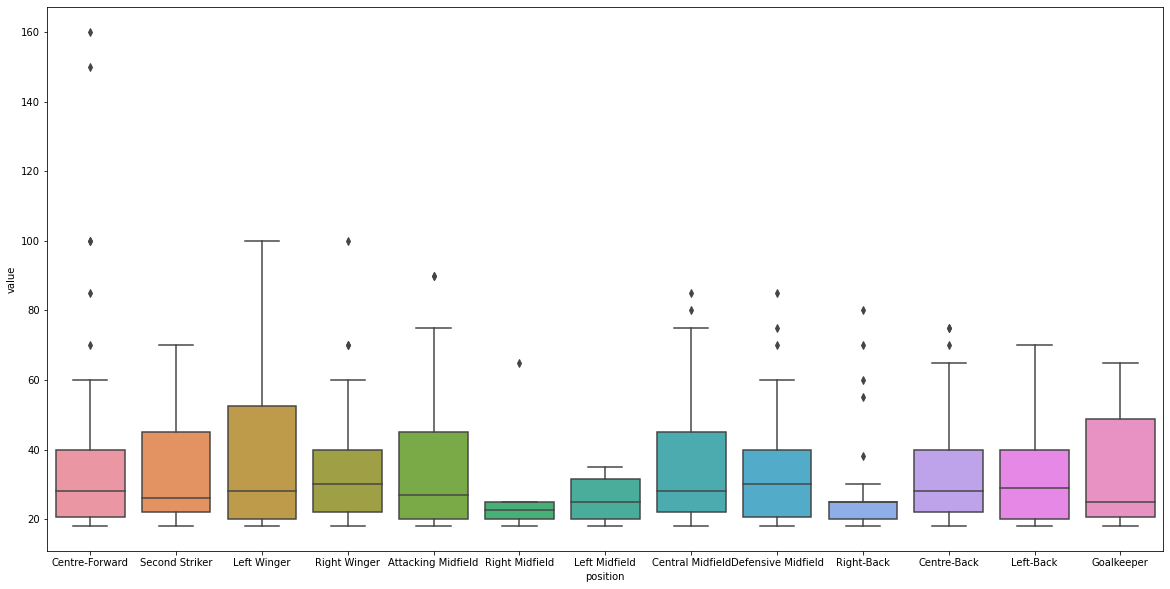

In [30]:
# Left Winger, Attacking Mid, Centre-Forward, Centre Mid 순으로 몸값이 높다.
plt.figure(figsize=(20,10))
sns.boxplot('position', 'value', data=data, order=('Centre-Forward', 'Second Striker', 'Left Winger', 'Right Winger', 'Attacking Midfield', 'Right Midfield', 'Left Midfield', 'Central Midfield', 'Defensive Midfield', 'Right-Back', 'Centre-Back', 'Left-Back', 'Goalkeeper'))

<AxesSubplot:xlabel='position', ylabel='value'>

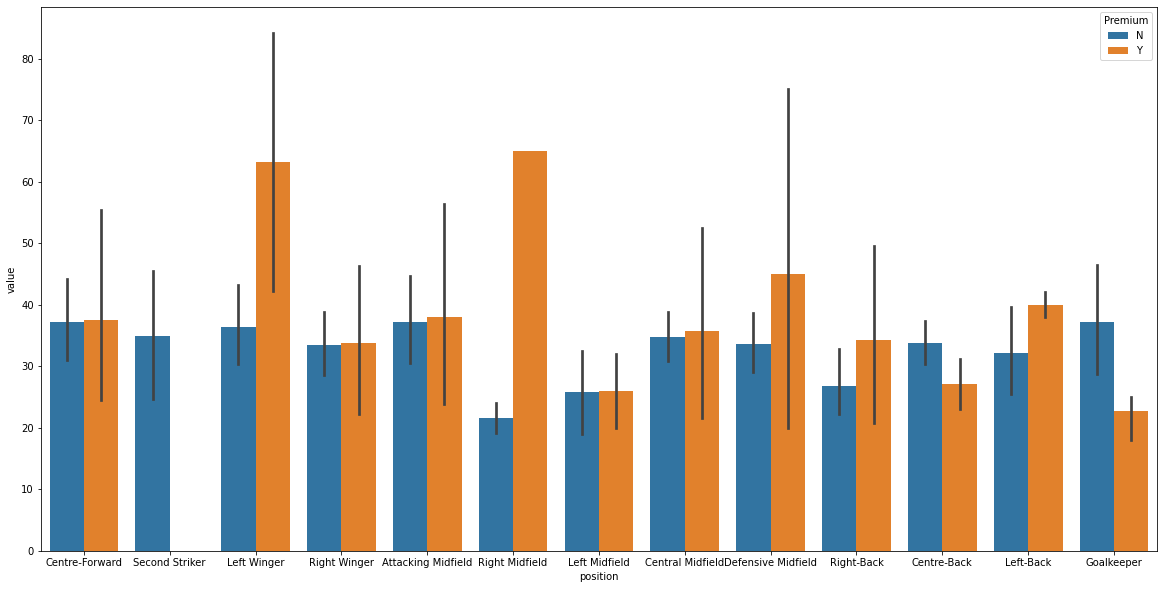

In [29]:
# 영국국적 선수와 영국국적이 아닌 선수의 포지션별 value 차이 파악해보기
plt.figure(figsize=(20,10))
sns.barplot(x='position', y='value', hue='Premium', data=premium, order=('Centre-Forward', 'Second Striker', 'Left Winger', 'Right Winger', 'Attacking Midfield', 'Right Midfield', 'Left Midfield', 'Central Midfield', 'Defensive Midfield', 'Right-Back', 'Centre-Back', 'Left-Back', 'Goalkeeper'))

In [52]:
### 3. 가장 많이 뛰는 리그와 몸값 차이
data.groupby('league')['name'].count().sort_values(ascending=False)

league
Premier League        183
Serie A                84
LaLiga                 77
Bundesliga             63
Ligue 1                47
Liga Portugal          15
Eredivisie             10
Premier Liga            8
Other                   7
Jupiler Pro League      3
Championship            2
Premiership             1
Name: name, dtype: int64

<AxesSubplot:xlabel='league'>

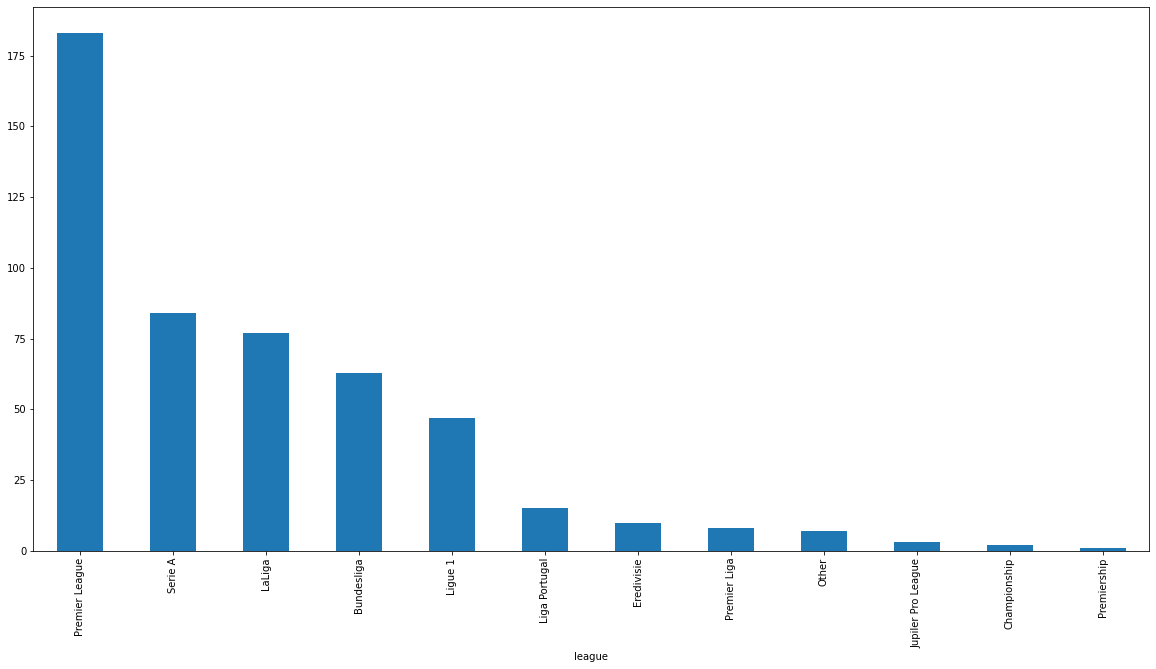

In [53]:
data.groupby('league')['name'].count().sort_values(ascending=False).plot(kind='bar', figsize=(20,10))

/Users/hoon/miniforge3/envs/ML/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='league', ylabel='value'>

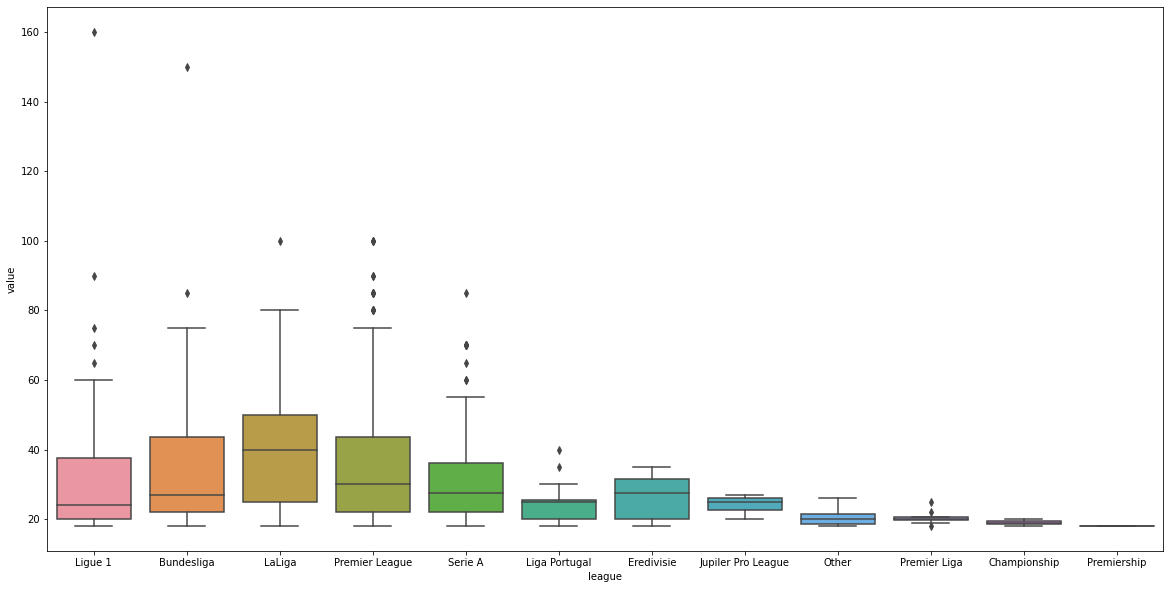

In [31]:
plt.figure(figsize=(20,10))
sns.boxplot('league', 'value', data=data)

In [59]:
premium.groupby('club')['name'].count().sort_values(ascending=False).head(20)

club
Chelsea FC             18
Manchester City        17
Manchester United      16
Liverpool FC           16
Paris Saint-Germain    15
Bayern Munich          14
Everton FC             14
Atlético de Madrid     14
Real Madrid            14
Tottenham Hotspur      14
Arsenal FC             13
FC Barcelona           13
RB Leipzig             12
Aston Villa            12
Atalanta BC            12
AC Milan               12
Juventus FC            11
SSC Napoli             11
Leicester City         11
Borussia Dortmund      10
Name: name, dtype: int64

<AxesSubplot:xlabel='club'>

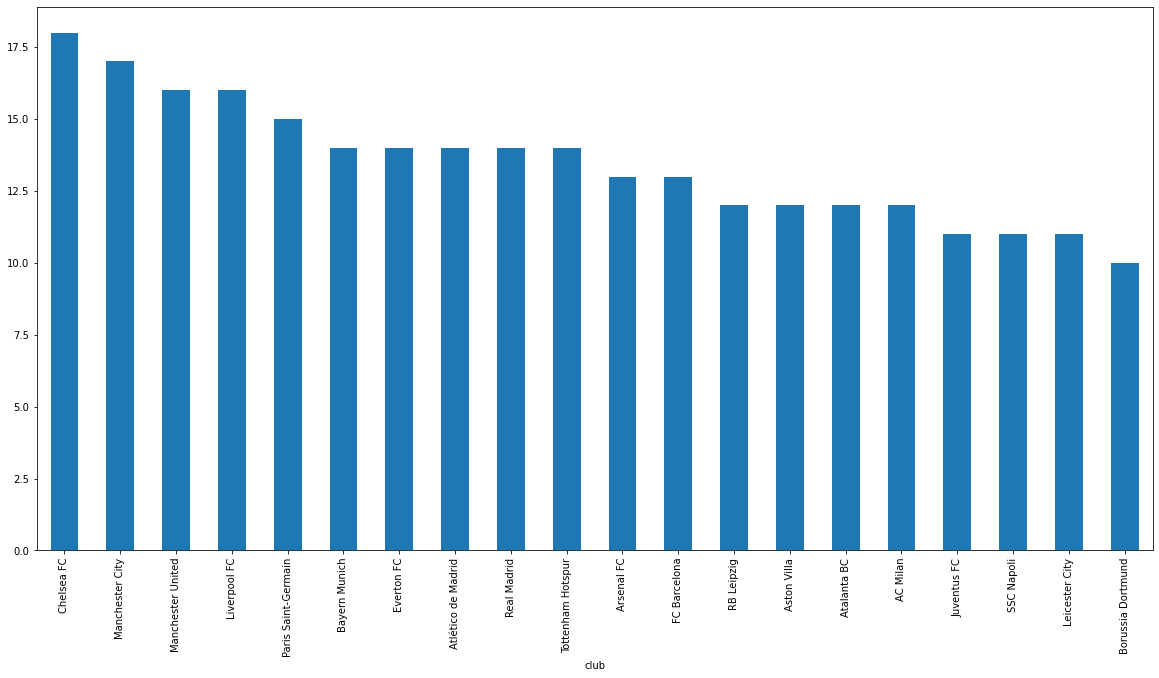

In [58]:
premium.groupby('club')['name'].count().sort_values(ascending=False).head(20).plot(kind='bar', figsize=(20,10))

In [60]:
# 클럽 내 선수들 몸값 총합이 가장 큰 순서대로
premium.groupby('club')['value'].sum().sort_values(ascending=False).head(20)

club
Manchester City        956.0
Chelsea FC             815.0
Liverpool FC           793.0
Paris Saint-Germain    792.0
Bayern Munich          737.0
Manchester United      730.0
Real Madrid            666.0
Atlético de Madrid     590.0
FC Barcelona           564.0
Tottenham Hotspur      493.0
Inter Milan            456.0
Juventus FC            448.0
Borussia Dortmund      442.0
Arsenal FC             430.0
Leicester City         405.0
SSC Napoli             401.0
AC Milan               392.0
RB Leipzig             373.0
Everton FC             366.0
Aston Villa            350.0
Name: value, dtype: float64

<AxesSubplot:xlabel='club'>

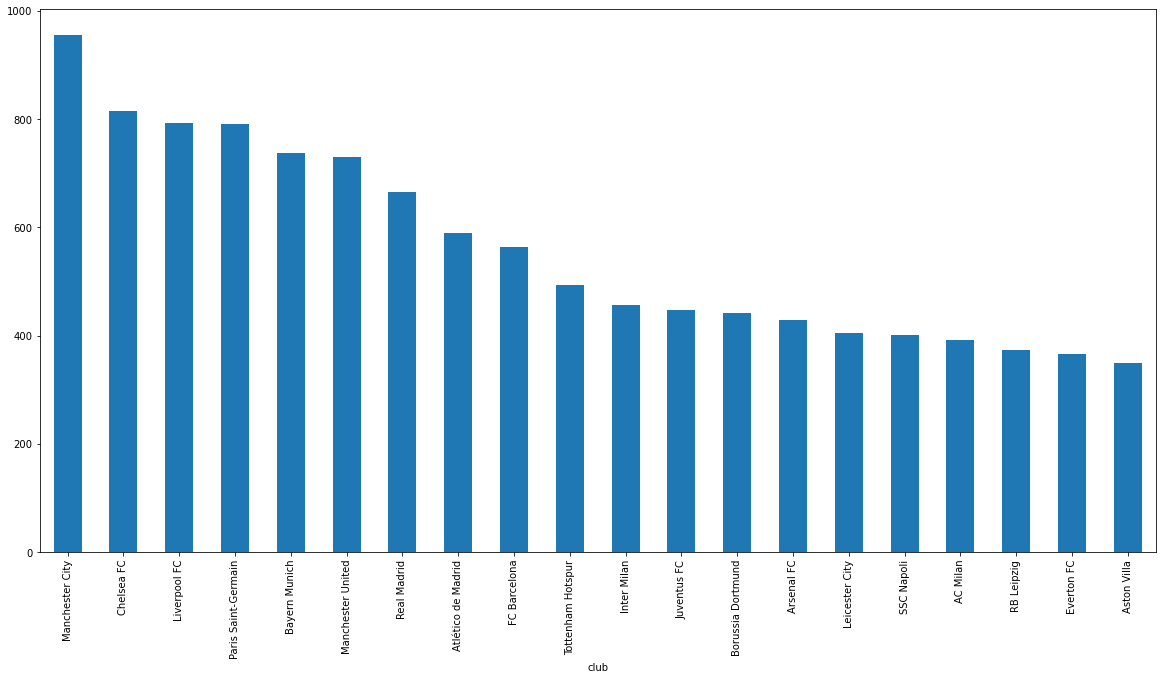

In [61]:
premium.groupby('club')['value'].sum().sort_values(ascending=False).head(20).plot(kind='bar', figsize=(20,10))